Accuracy: 0.9382716049382716
Precision: 0.9821428571428571
Recall: 0.9322033898305084
F1 Score: 0.9565217391304348
ROC AUC Score: 0.9375963020030816


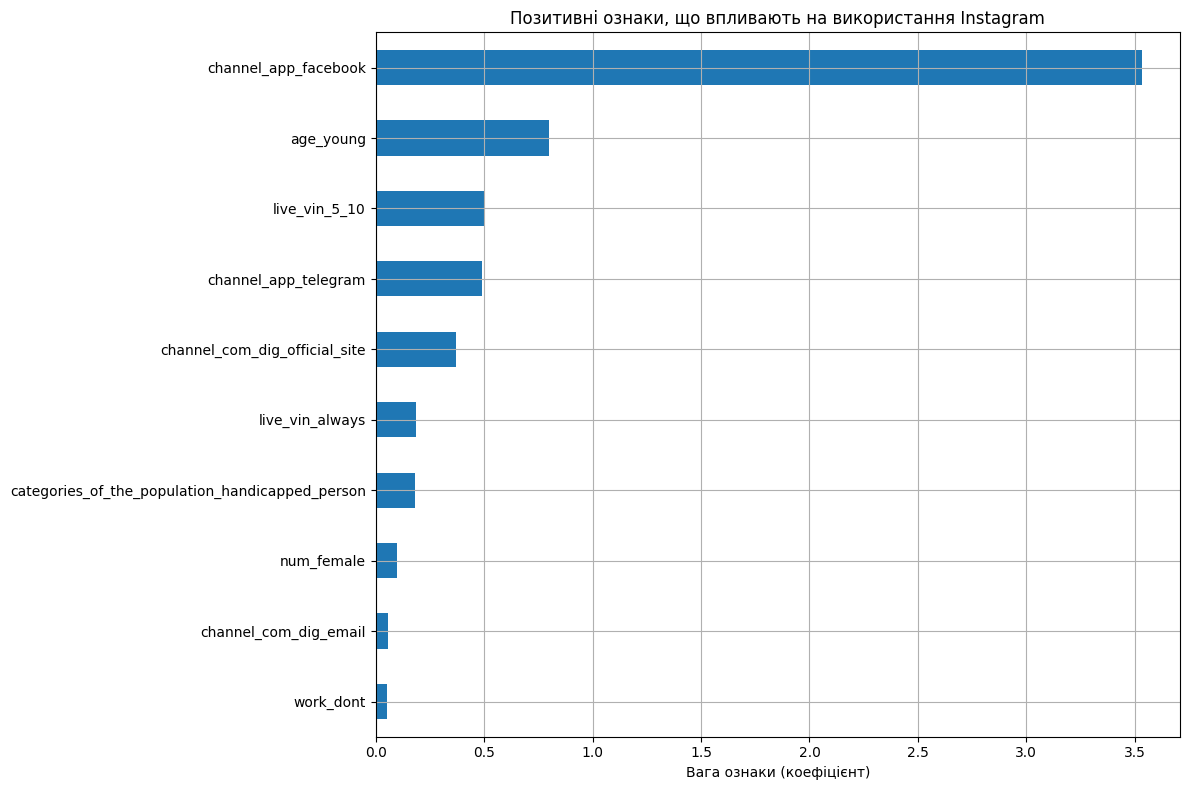

In [ ]:
# Встановлення бібліотек
!pip install --quiet gspread gspread_dataframe

# Імпорти
import pandas as pd
import numpy as np
import gspread
from gspread_dataframe import get_as_dataframe
from google.colab import auth
from google.auth import default
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Авторизація
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Завантаження та попередня обробка
df = pd.read_csv("/content/optimized_data.csv")
df = df.dropna(how='all').fillna(0)

# Заміна цільової змінної на Instagram
y = df['channel_app_instagram']
X = df.drop(columns=['channel_app_instagram'])

# Масштабування ознак
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Розділення на тренувальні та тестові дані
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Логістична регресія
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Позитивні ознаки
coef_series = pd.Series(model.coef_[0], index=X.columns)
positive_features = coef_series[coef_series > 0].sort_values()

# Оцінка моделі
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Візуалізація позитивних ознак
plt.figure(figsize=(12, 8))
positive_features.plot(kind='barh')
plt.title('Позитивні ознаки, що впливають на використання Instagram')
plt.xlabel('Вага ознаки (коефіцієнт)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Встановлення бібліотек
!pip install --quiet gspread gspread_dataframe xgboost

# Імпорти
import pandas as pd
import numpy as np
import gspread
from gspread_dataframe import get_as_dataframe
from google.colab import auth
from google.auth import default
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings("ignore")

# Авторизація
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Завантаження та обробка даних
df = pd.read_csv("/content/optimized_data.csv")
df = df.dropna(how='all').fillna(0)

# Цільова змінна — Instagram
y = df['channel_app_instagram']
X = df.drop(columns=['channel_app_instagram'])

# Лише числові ознаки
X = X.select_dtypes(include=[np.number])

# Масштабування
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Розділення даних
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Logistic Regression
log_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'max_iter': [100, 200, 500]
}
log_model = GridSearchCV(LogisticRegression(), log_params, cv=5, scoring='accuracy', n_jobs=-1)
log_model.fit(X_train, y_train)
log_best = log_model.best_estimator_

# Random Forest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}
rf_model = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_best = rf_model.best_estimator_

# XGBoost
xgb_params = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}
xgb_model = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    xgb_params, cv=5, scoring='accuracy', n_jobs=-1
)
xgb_model.fit(X_train, y_train)
xgb_best = xgb_model.best_estimator_

# Функція для метрик
def print_metrics(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred
    print(f"\n{name} Метрики:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Вивід метрик
print_metrics("Logistic Regression", log_best, X_test, y_test)
print_metrics("Random Forest", rf_best, X_test, y_test)
print_metrics("XGBoost", xgb_best, X_test, y_test)

# Найкращі параметри XGBoost
print("\nXGBoost найкращі параметри:")
print(xgb_model.best_params_)
print("Точність XGBoost на тренуванні:", accuracy_score(y_train, xgb_best.predict(X_train)))



Logistic Regression Метрики:
Accuracy: 0.9382716049382716
Precision: 0.9821428571428571
Recall: 0.9322033898305084
F1 Score: 0.9565217391304348
ROC AUC Score: 0.9414483821263483

Random Forest Метрики:
Accuracy: 0.9382716049382716
Precision: 0.9821428571428571
Recall: 0.9322033898305084
F1 Score: 0.9565217391304348
ROC AUC Score: 0.9291217257318952

XGBoost Метрики:
Accuracy: 0.9382716049382716
Precision: 0.9821428571428571
Recall: 0.9322033898305084
F1 Score: 0.9565217391304348
ROC AUC Score: 0.9406779661016951

XGBoost найкращі параметри:
{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Точність XGBoost на тренуванні: 0.9876543209876543


In [ ]:
# Імпорти
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# Завантаження даних
df = pd.read_csv("/content/optimized_data.csv")
df = df.dropna(how='all').fillna(0)

# Цільова змінна — Instagram
y = df['channel_app_instagram']
X = df.drop(columns=['channel_app_instagram'])
X = X.select_dtypes(include=[np.number])
# Масштабування
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Розділення даних
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
# === XGBoost ===
params_xgb = {  'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]}
model_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    param_grid=params_xgb, scoring='accuracy', cv=5, n_jobs=-1)
model_xgb.fit(X_train, y_train)
y_pred_train = model_xgb.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print("Точність XGBoost на тренувальних даних:", acc_train)
print("Найкращі гіперпараметри XGBoost:", model_xgb.best_params_)

# Logistic Regression
params_log = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'max_iter': [100, 200, 500]}
model_log = GridSearchCV(LogisticRegression(),param_grid=params_log,
    scoring='accuracy', cv=5, n_jobs=-1)
model_log.fit(X_train, y_train)
y_pred_train = model_log.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print("\nТочність Logistic Regression на тренувальних даних:", acc_train)
print("Найкращі гіперпараметри Logistic Regression:", model_log.best_params_)

#  Random Forest
params_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]}
model_rf = GridSearchCV(RandomForestClassifier(),
    param_grid=params_rf,scoring='accuracy', cv=5,n_jobs=-1)
model_rf.fit(X_train, y_train)
y_pred_train = model_rf.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print("\nТочність Random Forest на тренувальних даних:", acc_train)
print("Найкращі гіперпараметри Random Forest:", model_rf.best_params_)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:16:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Точність XGBoost на тренувальних даних: 0.9876543209876543
Найкращі гіперпараметри XGBoost: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}

Точність Logistic Regression на тренувальних даних: 0.9845679012345679
Найкращі гіперпараметри Logistic Regression: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

Точність Random Forest на тренувальних даних: 0.9907407407407407
Найкращі гіперпараметри Random Forest: {'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


<Figure size 600x500 with 0 Axes>

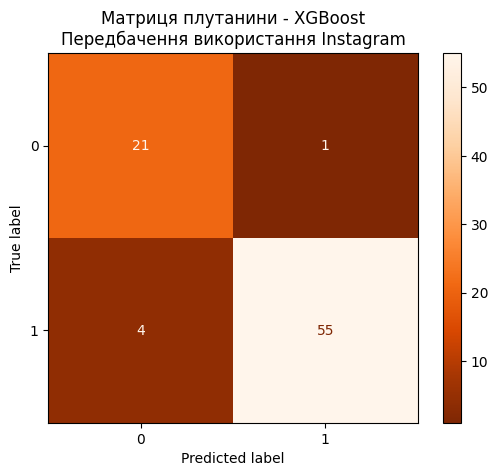

<Figure size 600x500 with 0 Axes>

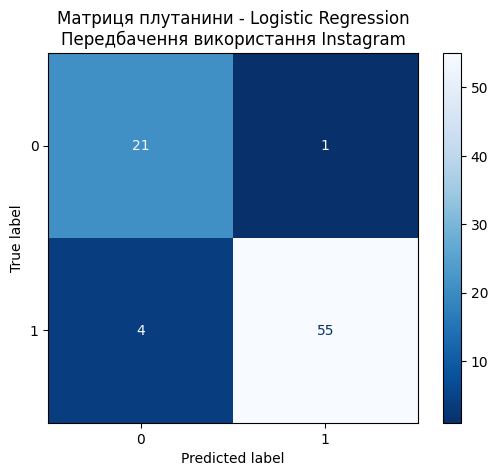

<Figure size 600x500 with 0 Axes>

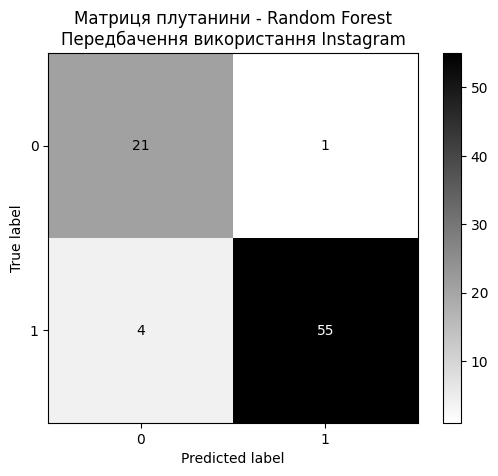

Точність моделей на тестових даних (channel_app_instagram):
XGBoost:             0.9383
Logistic Regression: 0.9383
Random Forest:       0.9383


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
#  XGBoost
y_pred_xgb = xgb_best.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
ConfusionMatrixDisplay(cm_xgb).plot(cmap='Oranges_r', values_format='d')
plt.title('Матриця плутанини - XGBoost\nПередбачення використання Instagram')
plt.show()
#  Logistic Regression
y_pred_log = log_best.predict(X_test)
acc_log = accuracy_score(y_test, y_pred_log)
plt.figure(figsize=(6, 5))
cm_log = confusion_matrix(y_test, y_pred_log)
ConfusionMatrixDisplay(cm_log).plot(cmap='Blues_r', values_format='d')
plt.title('Матриця плутанини - Logistic Regression\nПередбачення використання Instagram')
plt.show()
#  Random Forest
y_pred_rf = rf_best.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
cm_rf = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm_rf).plot(cmap='binary', values_format='d')
plt.title('Матриця плутанини - Random Forest\nПередбачення використання Instagram')
plt.show()
#  Підсумкова точність
print("Точність моделей на тестових даних (channel_app_instagram):")
print(f"XGBoost:             {acc_xgb:.4f}")
print(f"Logistic Regression: {acc_log:.4f}")
print(f"Random Forest:       {acc_rf:.4f}")


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Оновлена цільова змінна
y = df['channel_app_instagram']
X = df.drop(columns=['channel_app_instagram'])

from sklearn.preprocessing import StandardScaler
X = X.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Розділення на тренувальні та тестові дані
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Словник моделей
models = {'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)}
# Порівняння моделей
for name, model in models.items():
    # Крос-валідація
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    # Навчання і точність
    model.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    # Виведення результатів
    print(f"\n{name} (Instagram):")
    print(f"Крос-валідація:     середнє = {cv_mean:.3f}, std = {cv_std:.3f}")
    print(f"Точність train:     {train_acc:.3f}")
    print(f"Точність test:      {test_acc:.3f}")
    if train_acc - test_acc > 0.1:
        print("Можливе перенавчання (overfitting)")
    else:
        print("Модель узагальнює добре")



LogisticRegression (Instagram):
Крос-валідація:     середнє = 0.972, std = 0.018
Точність train:     0.981
Точність test:      0.938
Модель узагальнює добре

RandomForest (Instagram):
Крос-валідація:     середнє = 0.966, std = 0.020
Точність train:     0.997
Точність test:      0.938
Модель узагальнює добре

XGBoost (Instagram):
Крос-валідація:     середнє = 0.978, std = 0.016
Точність train:     0.994
Точність test:      0.938
Модель узагальнює добре
